In [3]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl

import sys
if "../src/" not in sys.path:
    sys.path.insert(0,"../src/")
from pbcpy.grid import DirectGrid, ReciprocalGrid
from pbcpy.field import DirectField, ReciprocalField
from pbcpy.functionals import *
%matplotlib inline
%load_ext autoreload
%autoreload 2
#

In [4]:
from pbcpy.local_functionals_utils import ThomasFermiEnergy, ThomasFermiPotential
from pbcpy.local_functionals_utils import vonWeizsackerEnergy, vonWeizsackerPotential
from pbcpy.formats.qepp import PP
from pbcpy.formats.xsf import XSF
from pbcpy.local_functionals_utils import x_TF_y_vW 
from pbcpy.nonlocal_functionals_utils import LindhardFunction, MGP_kernel, WT_kernel
from pbcpy.local_pseudopotential import NuclearElectron
from pbcpy.hartree import HartreeFunctional

In [5]:
def data_read(i):
    print(i)
    density = PP('../../Densities2/Al_'+str(i)+'_0_fde_0rho.pp').read()
    kin_pot = PP('../../Potentials2/Al_'+str(i)+'_0_vt_rhotot_alph.pp').read()
    density =density.field
    kin_pot =kin_pot.field/2.
#    ThomasFermi = Functional(name='TF',energydensity=ThomasFermiEnergy(data_dens), potential=ThomasFermiPotential(data_dens))
#    vonWeizsacker = Functional(name='vW',energydensity=vonWeizsackerEnergy(data_dens), potential=vonWeizsackerPotential(data_dens,Sigma=0.1))
    ThomasFermi = Functional(name='TF',energydensity=ThomasFermiEnergy(density), potential=ThomasFermiPotential(density))
    vonWeizsacker = Functional(name='vW',energydensity=vonWeizsackerEnergy(density), potential=vonWeizsackerPotential(density,Sigma=0.1))
    
    potential_NL= kin_pot - ThomasFermi.potential - vonWeizsacker.potential
    return density, potential_NL

#line
#first input adds 1, second input adds 10 lines, third input adds 500 lines

In [6]:
# Initializing arrays which are going to be filled with the data

# in data_pot we store the nonlocal part of the potential
data_dens = []
data_pot = []
for j in range(1,101):
    density,potential_NL = data_read(j)
    data_dens.append(density) 
    data_pot.append(potential_NL)
print(np.shape(data_dens))
print(np.shape(data_pot))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
(100, 50, 50, 50, 1)
(100, 50, 50, 50, 1)


In [7]:
dens = np.empty(0)
#for i in data_dens:
   # for j in i:
       # for k in j:
dens = np.append(dens, [data_dens])
print(dens)

print(np.shape(dens))
 

[0.03834769 0.03818566 0.03755185 ... 0.00721807 0.00728932 0.00739384]
(12500000,)


In [8]:
pot = np.empty(0)

#for i in data_pot:
 #   for j in i:
  #      for k in j:
   #         for l in k:
    #            for m in l:
pot = np.append(pot, [data_pot])
print(pot)
print(np.shape(pot))

[-0.20891083 -0.19885851 -0.18338002 ...  0.1642718   0.16283395
  0.16087878]
(12500000,)


In [9]:
dens1 = dens.reshape(-1,1)
pot1 = pot.reshape(-1,1)
print(np.shape(dens1))
print(np.shape(pot1))

(12500000, 1)
(12500000, 1)


In [10]:
#dens_train = dens1[0:1000000]
#dens_test = dens1[1000000:1250000]
#pot_train = pot1[0:1000000]
#pot_test = pot1[1000000:1250000]
x = 0
y = 100
a = 0
b = 100
dens_test = 0
pot_test = 0
dens_train = 0
pot_train = 0
   
for j in range(81,101):
    dens_test = np.append(dens_test, dens1[(a + 10000000) : (b + 10000000)])
    pot_test = np.append(pot_test, pot1[(a + 10000000) : (b + 10000000)])
    a = a + 125000
    b = b + 125000

for i in range(1,81):
    dens_train = np.append(dens_train, dens1[x:y])
    pot_train = np.append(pot_train, pot1[x:y])
    x = x + 125000
    y = y + 125000    
    
#dens_train = dens1[0:8000]
#dens_test = dens1[8000:10000]
#pot_train = pot1[0:8000]
#pot_test = pot1[8000:10000]


print(np.shape(dens_train))
print(np.shape(pot_train))
print(dens_train)
print(pot_test)
print(np.shape(dens_test))
print(np.shape(pot_test))

(8001,)
(8001,)
[0.         0.03834769 0.03818566 ... 0.02058347 0.01975099 0.0188323 ]
[0.         0.17506589 0.16703814 ... 0.12603598 0.12983985 0.13364872]
(2001,)
(2001,)


In [11]:
dens_train1 = dens_train[1:8001]
pot_train1 = pot_train[1:8001]
pot_test1 = pot_test[1:2001]
dens_test1 = dens_train[1:2001]

dens_train1 = dens_train1.reshape(-1,1)
dens_test1=dens_test1.reshape(-1,1)
pot_train1 = pot_train1.reshape(-1,1)
pot_test1=pot_test1.reshape(-1,1)

print(np.shape(dens_train1))
print(np.shape(pot_train1))
print(np.shape(dens_test1))
print(np.shape(pot_test1))

(8000, 1)
(8000, 1)
(2000, 1)
(2000, 1)


In [12]:
from sklearn.neural_network import MLPRegressor

In [28]:
n_layer = [(10,), (12,), (20,) ]
solve = ['adam','lbfgs','sgd']
alpha = [.1, .01, .001]
score_array_2 = np.zeros((len(solve),len(n_layer),len(alpha)))
inner = 0
inner2 = 0
inner3 = 0
for j in n_layer:
    inner2 = 0
    for i in solve:
        inner3 = 0
        for h in alpha:
            modelnn = MLPRegressor(hidden_layer_sizes= j, alpha = h, solver = i)
            modelnn.fit(dens_train1, np.ravel(pot_train1))
            predict_nn = modelnn.predict(dens_test1)
            score = 0.1*(1/2000)*np.sum(np.abs((predict_nn[:]-pot_test1[:])/pot_test1[:]))
            print('n_layer: ',j,'solver: ',i, 'alpha:', h, 'score: ',score)
            score_array_2[inner][inner2][inner3] = score
            print (score_array_2[inner][inner2][inner3])
            inner3 +=1
        inner2 += 1
    inner += 1

n_layer:  (10,) solver:  adam alpha: 0.1 score:  289.87906040380494
289.87906040380494
n_layer:  (10,) solver:  adam alpha: 0.01 score:  290.8590176738379
290.8590176738379
n_layer:  (10,) solver:  adam alpha: 0.001 score:  289.0183238590556
289.0183238590556
n_layer:  (10,) solver:  lbfgs alpha: 0.1 score:  583.9054691413075
583.9054691413075
n_layer:  (10,) solver:  lbfgs alpha: 0.01 score:  637.0214732415739
637.0214732415739
n_layer:  (10,) solver:  lbfgs alpha: 0.001 score:  585.8798689833873
585.8798689833873
n_layer:  (10,) solver:  sgd alpha: 0.1 score:  287.62373724883565
287.62373724883565
n_layer:  (10,) solver:  sgd alpha: 0.01 score:  289.31661387836857
289.31661387836857
n_layer:  (10,) solver:  sgd alpha: 0.001 score:  288.30961243591497
288.30961243591497
n_layer:  (12,) solver:  adam alpha: 0.1 score:  299.58442652605476
299.58442652605476
n_layer:  (12,) solver:  adam alpha: 0.01 score:  291.9567905246089
291.9567905246089
n_layer:  (12,) solver:  adam alpha: 0.001 sc

adam (10,) [289.8790604  290.85901767 289.01832386]
adam (12,) [583.90546914 637.02147324 585.87986898]
adam (20,) [287.62373725 289.31661388 288.30961244]
lbfgs (10,) [299.58442653 291.95679052 536.65896081]
lbfgs (12,) [626.25601473 587.56706074 587.42882498]
lbfgs (20,) [289.00025248 290.7172868  291.71981884]
sgd (10,) [292.60830272 519.11069438 567.60009395]
sgd (12,) [584.1112307  586.61259595 587.24826361]
sgd (20,) [291.3388923  294.22797908 291.21072342]


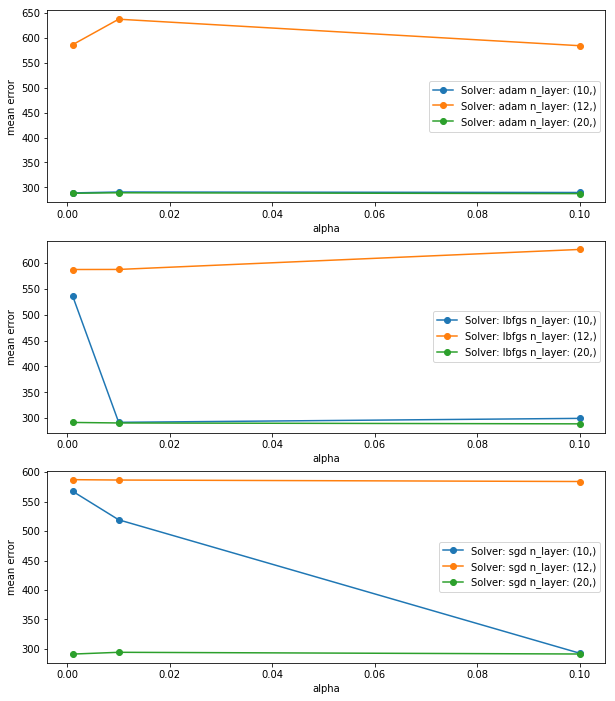

In [29]:
#plotting the mean error
mpl.rcParams['figure.figsize'] = (10,12)
fig, axes = plt.subplots(nrows=3,ncols=1)
for i in range(len(solve)):
    for j in range(len(n_layer)):
        print (solve[i],n_layer[j], score_array_2[i][j])
        axes[i].plot(alpha,score_array_2[i][j],label = 'Solver: '+solve[i]+' n_layer: '+str(n_layer[j]), marker = 'o')
        axes[i].set_xlabel('alpha')
        axes[i].set_ylabel('mean error')
        axes[i].legend()
plt.show()

In [20]:
#figuring out which point yields the lowest mean error
model_adam = MLPRegressor(solver = 'adam', hidden_layer_sizes = 12,random_state=0, max_iter=1000, alpha = .90)
model_lbfgs = MLPRegressor(solver = 'lbfgs', hidden_layer_sizes = 12,random_state=0, max_iter=1000, alpha = .30)
model_sgd = MLPRegressor(solver = 'sgd', hidden_layer_sizes = 12, random_state=0, max_iter=1000, alpha = 30)
  

#fitting the solvers to the data
model_adam.fit(dens_train1, np.ravel(pot_train1))
model_lbfgs.fit(dens_train1, np.ravel(pot_train1))
model_sgd.fit(dens_train1, np.ravel(pot_train1))

pred_adam = model_adam.predict(dens_test1)
pred_lbfgs = model_lbfgs.predict(dens_test1)
pred_sgd = model_sgd.predict(dens_test1)

import matplotlib.pyplot as plt

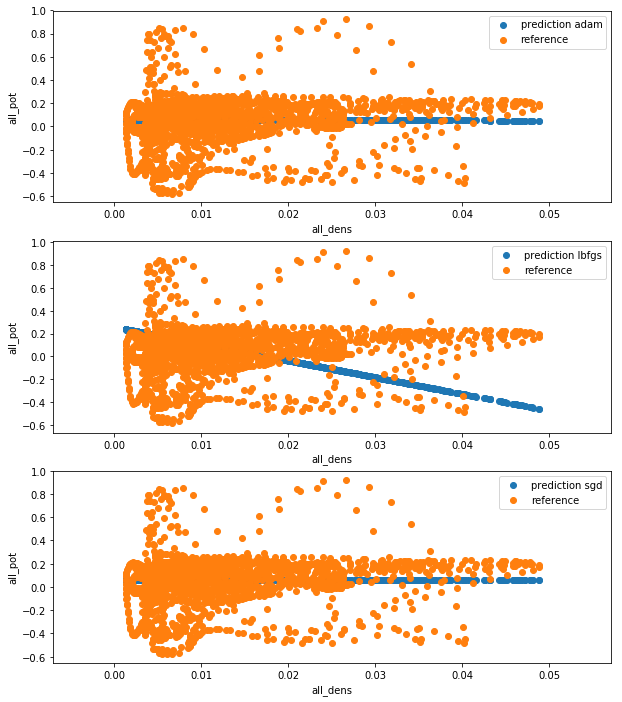

In [21]:
#seeing how accurate the prediction is
fig, axes = plt.subplots(nrows=3,ncols=1)

axes[0].scatter(dens_test1, pred_adam, label = 'prediction adam')
axes[0].scatter(dens_test1, pot_test1, label = 'reference')

axes[1].scatter(dens_test1, pred_lbfgs, label = 'prediction lbfgs')
axes[1].scatter(dens_test1, pot_test1, label = 'reference')

axes[2].scatter(dens_test1, pred_sgd, label = 'prediction sgd')
axes[2].scatter(dens_test1, pot_test1, label = 'reference')

#axes[0].set_ylim([-1,1])

for i in range(3):
    axes[i].set_xlabel('all_dens')
    axes[i].set_ylabel('all_pot')
    axes[i].legend()
    #axes[i].set_xlim(-0.002, 0.002)
plt.show()